<a href="https://colab.research.google.com/github/romitbarua/MultiModalDeepFake/blob/main/TestingNotebooks/MFCC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#https://www.kaggle.com/code/ilyamich/mfcc-implementation-and-tutorial/notebook

In [2]:
#!pip install moviepy
#!pip install ffmpeg
#!pip install imageio-ffmpeg
!pip install moviepy
!pip3 install imageio==2.4.1
!pip install --upgrade imageio-ffmpeg

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
import os
import numpy as np
import scipy
from scipy.io import wavfile
import scipy.fftpack as fft
from scipy.signal import get_window
import IPython.display as ipd
import matplotlib.pyplot as plt
import moviepy.editor as mp
%matplotlib inline

In [4]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [5]:
video_path = r'/content/drive/MyDrive/FakeAVCeleb/FakeAVCeleb_v1.2/RealVideo-RealAudio/African/men/id00076/00109.mp4'

In [6]:
video = mp.VideoFileClip(video_path)

In [16]:
#with mono conversion
video.audio.write_audiofile(r"/content/drive/MyDrive/FakeAVCeleb/FakeAVCeleb_v1.2/RealVideo-RealAudio/African/men/id00076/00109.wav",
                            ffmpeg_params=["-ac", "1"])

[MoviePy] Writing audio in /content/drive/MyDrive/FakeAVCeleb/FakeAVCeleb_v1.2/RealVideo-RealAudio/African/men/id00076/00109.wav


100%|██████████| 223/223 [00:00<00:00, 1881.76it/s]

[MoviePy] Done.


In [17]:
audio_file = r'/content/drive/MyDrive/FakeAVCeleb/FakeAVCeleb_v1.2/RealVideo-RealAudio/African/men/id00076/00109.wav'

In [18]:
ipd.Audio(audio_file)

In [19]:
sample_rate, audio = wavfile.read(audio_file)
print("Sample rate: {0}Hz".format(sample_rate))
print("Audio duration: {0}s".format(len(audio) / sample_rate))

Sample rate: 44100Hz
Audio duration: 10.1s


In [20]:
def normalize_audio(audio):
    audio = audio / np.max(np.abs(audio))
    return audio

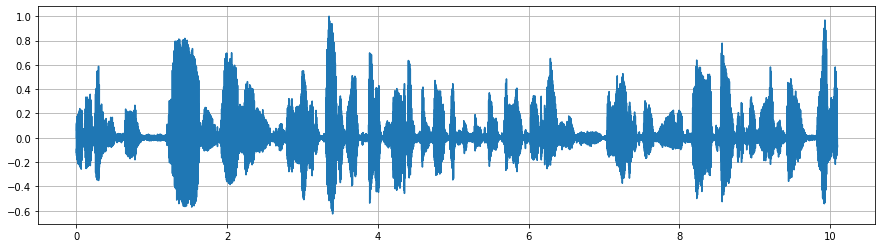

In [21]:
audio = normalize_audio(audio)
plt.figure(figsize=(15,4))
plt.plot(np.linspace(0, len(audio) / sample_rate, num=len(audio)), audio)
plt.grid(True)

In [22]:
def frame_audio(audio, FFT_size=2048, hop_size=10, sample_rate=44100):
    # hop_size in ms
    
    audio = np.pad(audio, int(FFT_size / 2), mode='reflect')
    frame_len = np.round(sample_rate * hop_size / 1000).astype(int)
    frame_num = int((len(audio) - FFT_size) / frame_len) + 1
    frames = np.zeros((frame_num,FFT_size))
    
    for n in range(frame_num):
        frames[n] = audio[n*frame_len:n*frame_len+FFT_size]
    
    return frames

In [24]:
hop_size = 10 #ms
FFT_size = 2048

audio_framed = frame_audio(audio, FFT_size=FFT_size, hop_size=hop_size, sample_rate=sample_rate)
print("Framed audio shape: {0}".format(audio_framed.shape))

Framed audio shape: (1011, 2048)


In [25]:
print("First frame:")
audio_framed[1]

First frame:


array([ 0.01012206,  0.0066488 ,  0.00119083, ..., -0.15669346,
       -0.16830406, -0.10866329])

In [26]:
print("Last frame:")
audio_framed[-1]

Last frame:


array([0.03245013, 0.02689292, 0.02242731, ..., 0.02689292, 0.03245013,
       0.03880123])

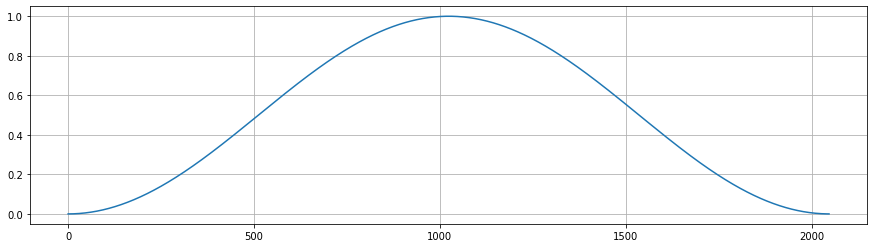

In [27]:
window = get_window("hann", FFT_size, fftbins=True)
plt.figure(figsize=(15,4))
plt.plot(window)
plt.grid(True)

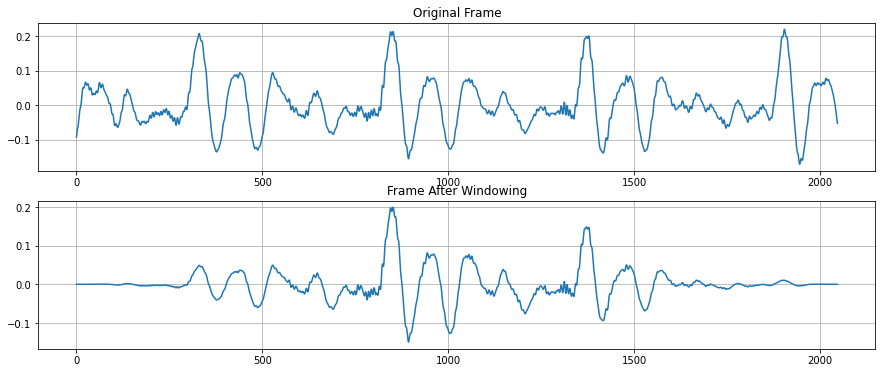

In [28]:
audio_win = audio_framed * window

ind = 69
plt.figure(figsize=(15,6))
plt.subplot(2, 1, 1)
plt.plot(audio_framed[ind])
plt.title('Original Frame')
plt.grid(True)
plt.subplot(2, 1, 2)
plt.plot(audio_win[ind])
plt.title('Frame After Windowing')
plt.grid(True)

In [29]:
audio_winT = np.transpose(audio_win)

audio_fft = np.empty((int(1 + FFT_size // 2), audio_winT.shape[1]), dtype=np.complex64, order='F')

for n in range(audio_fft.shape[1]):
    audio_fft[:, n] = fft.fft(audio_winT[:, n], axis=0)[:audio_fft.shape[0]]

audio_fft = np.transpose(audio_fft)

In [30]:
audio_power = np.square(np.abs(audio_fft))
print(audio_power.shape)

(1011, 1025)


In [32]:
freq_min = 0
freq_high = sample_rate / 2
mel_filter_num = 10

print("Minimum frequency: {0}".format(freq_min))
print("Maximum frequency: {0}".format(freq_high))

Minimum frequency: 0
Maximum frequency: 22050.0


In [33]:
def freq_to_mel(freq):
    return 2595.0 * np.log10(1.0 + freq / 700.0)

def met_to_freq(mels):
    return 700.0 * (10.0**(mels / 2595.0) - 1.0)

In [34]:
def get_filter_points(fmin, fmax, mel_filter_num, FFT_size, sample_rate=44100):
    fmin_mel = freq_to_mel(fmin)
    fmax_mel = freq_to_mel(fmax)
    
    print("MEL min: {0}".format(fmin_mel))
    print("MEL max: {0}".format(fmax_mel))
    
    mels = np.linspace(fmin_mel, fmax_mel, num=mel_filter_num+2)
    freqs = met_to_freq(mels)
    
    return np.floor((FFT_size + 1) / sample_rate * freqs).astype(int), freqs

In [35]:
filter_points, mel_freqs = get_filter_points(freq_min, freq_high, mel_filter_num, FFT_size, sample_rate=44100)
filter_points

MEL min: 0.0
MEL max: 3923.337321740179


array([   0,   12,   28,   51,   82,  125,  184,  265,  376,  528,  737,
       1024])

In [36]:
def get_filters(filter_points, FFT_size):
    filters = np.zeros((len(filter_points)-2,int(FFT_size/2+1)))
    
    for n in range(len(filter_points)-2):
        filters[n, filter_points[n] : filter_points[n + 1]] = np.linspace(0, 1, filter_points[n + 1] - filter_points[n])
        filters[n, filter_points[n + 1] : filter_points[n + 2]] = np.linspace(1, 0, filter_points[n + 2] - filter_points[n + 1])
    
    return filters

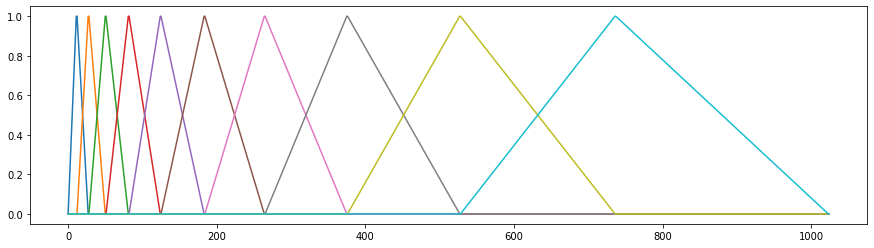

In [39]:
filters = get_filters(filter_points, FFT_size)

plt.figure(figsize=(15,4))
for n in range(filters.shape[0]):
    plt.plot(filters[n])

In [40]:
# taken from the librosa library
enorm = 2.0 / (mel_freqs[2:mel_filter_num+2] - mel_freqs[:mel_filter_num])
filters *= enorm[:, np.newaxis]

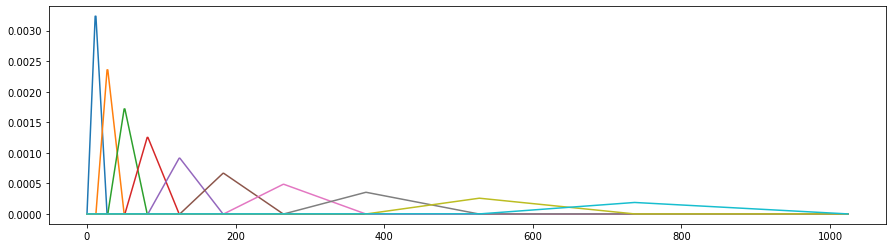

In [41]:
plt.figure(figsize=(15,4))
for n in range(filters.shape[0]):
    plt.plot(filters[n])

In [42]:
audio_filtered = np.dot(filters, np.transpose(audio_power))
audio_log = 10.0 * np.log10(audio_filtered)
audio_log.shape

(10, 1011)

In [43]:
def dct(dct_filter_num, filter_len):
    basis = np.empty((dct_filter_num,filter_len))
    basis[0, :] = 1.0 / np.sqrt(filter_len)
    
    samples = np.arange(1, 2 * filter_len, 2) * np.pi / (2.0 * filter_len)

    for i in range(1, dct_filter_num):
        basis[i, :] = np.cos(i * samples) * np.sqrt(2.0 / filter_len)
        
    return basis

In [44]:
dct_filter_num = 40

dct_filters = dct(dct_filter_num, mel_filter_num)

cepstral_coefficents = np.dot(dct_filters, audio_log)
cepstral_coefficents.shape

(40, 1011)

In [45]:
cepstral_coefficents[:, 0]

array([-6.10671693e+01,  3.98316544e+01, -3.42006021e+01,  4.05767302e+01,
       -1.30411168e+01,  3.28500438e+00, -4.64622412e+00,  3.02366924e+00,
       -1.23923319e+00, -3.02596980e+00,  1.28393184e-13,  3.02596980e+00,
        1.23923319e+00, -3.02366924e+00,  4.64622412e+00, -3.28500438e+00,
        1.30411168e+01, -4.05767302e+01,  3.42006021e+01, -3.98316544e+01,
        8.63620190e+01, -3.98316544e+01,  3.42006021e+01, -4.05767302e+01,
        1.30411168e+01, -3.28500438e+00,  4.64622412e+00, -3.02366924e+00,
        1.23923319e+00,  3.02596980e+00, -1.67574004e-13, -3.02596980e+00,
       -1.23923319e+00,  3.02366924e+00, -4.64622412e+00,  3.28500438e+00,
       -1.30411168e+01,  4.05767302e+01, -3.42006021e+01,  3.98316544e+01])

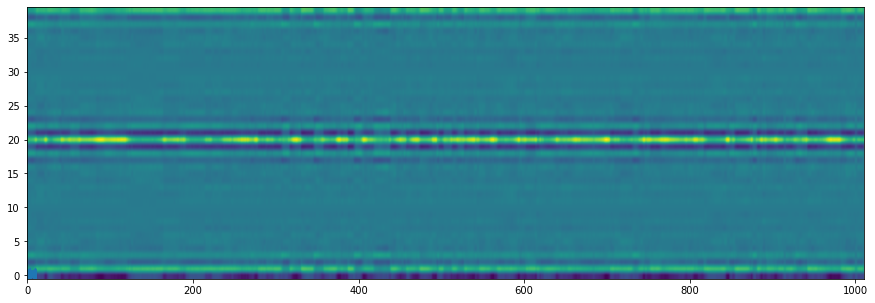

In [46]:
plt.figure(figsize=(15,5))
plt.plot(np.linspace(0, len(audio) / sample_rate, num=len(audio)), audio)
plt.imshow(cepstral_coefficents, aspect='auto', origin='lower');